In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from datetime import datetime

#print options to data exploration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)

In [60]:
#everyone can set their own while working. Personally I leave this blank because relative works for me
personal_path = ''
path_covid = os.path.join(personal_path, "Data/full_new.csv")
df = pd.read_csv(path_covid)
df['new_cases_per_million'].isna().sum()/len(df['new_cases_per_million'])

0.06943037201514793

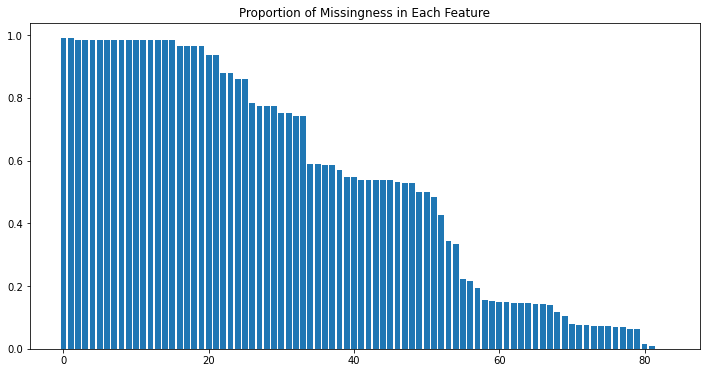

In [61]:
plt.figure(figsize=(12, 6))
plt.bar(x=np.arange(0, len(df.columns)), height = np.sort(df.isna().sum() / len(df))[::-1])
plt.title('Proportion of Missingness in Each Feature')
plt.show()

In [145]:
df = df.loc[:, df.isna().sum() / len(df) < 0.65]
df.columns

Index(['iso_code', 'date', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'new_tests',
       'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units',
       'new_vaccinations_smoothed', 'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed',
       'new_people_vaccinated_smoothed_per_hundred', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
     

In [146]:
df['date'] = pd.to_datetime(df['date'])
df['date_delta'] = (df['date'] - df['date'].min())  / np.timedelta64(1,'D')
df_sub = df[['date_delta','new_tests',
       'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate',
       'new_vaccinations_smoothed', 'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed',
       'new_people_vaccinated_smoothed_per_hundred','daily_people_vaccinated',
       'daily_people_vaccinated_per_hundred', 'daily_vaccinations',
       'daily_vaccinations_per_million']]
y = df[['new_cases_per_million']] #this is the field we want to predict

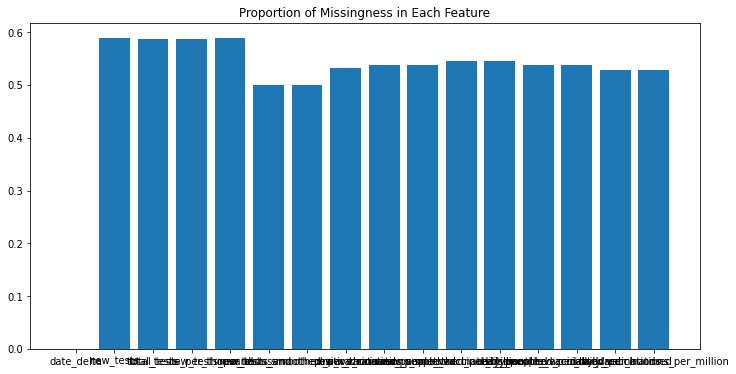

In [147]:
plt.figure(figsize=(12, 6))
plt.bar(x=df_sub.columns, height = df_sub.isna().sum() / len(df_sub))
plt.title('Proportion of Missingness in Each Feature')
plt.show()

In [148]:
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
train_X, validtest_X, train_y, validtest_y = train_test_split(df_sub, y, train_size = 0.8, random_state = 42, shuffle=False)
valid_X, test_X, valid_y, test_y = train_test_split(validtest_X, validtest_y, train_size = 0.5, random_state = 42, shuffle=False)

In [149]:
imputer_split = IterativeImputer(estimator = BayesianRidge(), max_iter = 20, min_value = df_sub.min(axis=0), max_value = df_sub.max(axis=0), random_state=42)
train_X_imputed = pd.DataFrame(imputer_split.fit_transform(train_X))
valid_X_imputed = pd.DataFrame(imputer_split.transform(valid_X))
test_X_imputed = pd.DataFrame(imputer_split.transform(test_X))
train_X_imputed.columns = df_sub.columns
valid_X_imputed.columns = df_sub.columns
test_X_imputed.columns = df_sub.columns
# is it ok to impute on test with train  data
# use an easy imputer
train_y_imputed = train_y.fillna(method='ffill')
valid_y_imputed = valid_y.fillna(method='ffill')
test_y_imputed = test_y.fillna(method='ffill')

/home/neha/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [153]:
def make_time_stepped(X, y, t):
    X_new = []
    y_new = []
    for i in range(math.floor(len(y) / t)):
        start_date = X.iloc[t*i]['date_delta']
        data_side = X.iloc[t*i:t*i + t]['date_delta']
        check_side = [start_date + j for j in range(t)]
        equality_condition = (data_side == check_side).all()
        if len(X.iloc[t*i:t*i + t]) == t:
            if equality_condition:
                y_new.append(y[t*i:t*i + t].sum()) #delta cases
                X_new.append(X[t*i:t*i + t])
    return X_new, y_new

In [155]:
t = 5
train_X_timed, train_y_timed = make_time_stepped(train_X_imputed, train_y_imputed, t)
valid_X_timed, valid_y_timed = make_time_stepped(valid_X_imputed, valid_y_imputed, t)
test_X_timed, test_y_timed = make_time_stepped(test_X_imputed, test_y_imputed, t)

In [156]:
train_X_timed = np.moveaxis(np.dstack(train_X_timed), 2, 0)
valid_X_timed = np.moveaxis(np.dstack(valid_X_timed), 2, 0)
test_X_timed = np.moveaxis(np.dstack(test_X_timed), 2, 0)

In [157]:
from torch.utils.data import TensorDataset, DataLoader
import torch

# TODO might want to change batch size
batch_size = 64

# Convert all feature and outcome numpy arrays into tensors
train_features = torch.Tensor(train_X_timed)
train_targets = torch.Tensor(train_y_timed)
val_features = torch.Tensor(valid_X_timed)
val_targets = torch.Tensor(valid_y_timed)
test_features = torch.Tensor(test_X_timed)
test_targets = torch.Tensor(test_y_timed)

# Combine feature and outcome tensors into TensorDatasets
train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

# Load TensorDatasets into DataLoader
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
# Extra DataLoader with batch size 1
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [158]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        # Initialize hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [159]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [160]:
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
    }
    return models.get(model.lower())(**model_params)

In [161]:
device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [162]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()
    
    def train(self, train_loader, val_loader, model_path, batch_size=64, n_epochs=50, n_features=1):

        # Each epoch iterates over each mini-batch of training data, 
        # executes train_step(), and calculates loss for validation batches
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)
    
    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values
    
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

[1/100] Training loss: 1030855.6119	 Validation loss: 2097777.9940
[2/100] Training loss: 1023583.1804	 Validation loss: 2089775.6293
[3/100] Training loss: 1016884.4646	 Validation loss: 2082072.2855
[4/100] Training loss: 1010415.5513	 Validation loss: 2074596.5004
[5/100] Training loss: 1004142.8628	 Validation loss: 2067323.8204
[6/100] Training loss: 998051.1786	 Validation loss: 2060240.8624
[7/100] Training loss: 992130.9307	 Validation loss: 2053338.3277
[8/100] Training loss: 986375.0499	 Validation loss: 2046609.7908
[9/100] Training loss: 980777.9416	 Validation loss: 2040049.4796
[10/100] Training loss: 975334.7655	 Validation loss: 2033652.8009
[50/100] Training loss: 851150.4890	 Validation loss: 1879501.0595
[100/100] Training loss: 818551.5739	 Validation loss: 1828681.9295


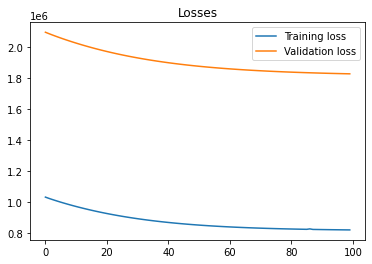

In [163]:
import torch.optim as optim

input_dim = len(train_X.columns)
output_dim = 1
hidden_dim = 32
layer_dim = 3
dropout = 0.2
n_epochs = 100 #train for more epochs
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = get_model('rnn', model_params)  # Change this line if you want a different model ('rnn')

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, 'models/rnn_start.pt', batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [164]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def format_predictions(predictions, values, df_test):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    #df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result

def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.value, df.prediction),
            'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
            'r2' : r2_score(df.value, df.prediction)}

df_result = format_predictions(predictions, values, test_X)
result_metrics = calculate_metrics(df_result)

In [165]:
result_metrics

{'mae': 453.61313, 'rmse': 676.0149776447264, 'r2': -0.028232147243744565}